In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
# Cargamos el template
template = cv.imread('assets\\template\\pattern.png', 0)

## Ejercicio 1

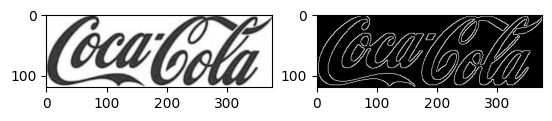

In [3]:
# Recorto template para tener un mejor match
x1, y1 = 10, 30  # Coordenadas de la esquina superior izquierda
x2, y2 = 385, 150  # Coordenadas de la esquina inferior derecha
trimmed_template = template[y1:y2, x1:x2]
template_canny = cv.Canny(trimmed_template, 100, 200)

plt.figure()
plt.subplot(121),plt.imshow(trimmed_template, cmap='gray')
plt.subplot(122),plt.imshow(template_canny, cmap='gray')
plt.show()

In [4]:
# Cargamos las imagenes
base_path = 'assets\images'
image_names = ['coca_logo_1.png', 'coca_logo_2.png', 'coca_retro_1.png', 'coca_retro_2.png', 'COCA-COLA-LOGO.jpg', 'logo_1.png']

images = [cv.imread(f"{base_path}\{path}") for path in image_names]
images_rgb = [cv.cvtColor(image, cv.COLOR_BGR2RGB) for image in images]
images_gray = [cv.cvtColor(image, cv.COLOR_BGR2GRAY) for image in images]

In [5]:
def preProcessImage(image: np.ndarray, max_limit: int) -> np.ndarray:
    # remove_noise = cv.GaussianBlur(image, (3,3), 0)
    canny = cv.Canny(image, 100, max_limit)
    return canny

In [6]:
def matchTemplate(image, template, method):
    result = cv.matchTemplate(image, template, method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)
    return max_val, max_loc

def chooseBestMatch(image, template):
    img_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    updated_template =  template
    
    methods = [cv.TM_CCOEFF_NORMED]

    best_match = None
    best_score = 0
    best_location = None
    image_copy = image.copy()
    
    sigmas = np.linspace(70, 800, num=5)
    
    for sigma in sigmas:
        processed_image = preProcessImage(img_gray, sigma)
        processed_template = preProcessImage(updated_template, 200)
        
        
        scale_factors = np.linspace(0.4, 1.3, num=10)
        if processed_image.shape[1] > 1300:
            scale_factors = np.linspace(2, 5, num=30)

        templates = [cv.resize(processed_template, None, fx=scale, fy=scale, interpolation=cv.INTER_AREA) for scale in scale_factors]

        for templ in templates:
            if templ.shape[1] > processed_image.shape[1]:
                break
            for method in methods:
                score, location = matchTemplate(processed_image, templ, method)
                if score > best_score:
                    best_score = score
                    best_match = templ
                    best_location = location

    # Dibujar un rectángulo sobre el mejor match en la imagen original
    w, h = best_match.shape[::-1]
    bottom_right = (best_location[0] + w, best_location[1] + h)
    cv.rectangle(image_copy, best_location, bottom_right, (0,0,255), 2)

    return best_match, best_score, best_location, image_copy

In [7]:
def addScoreLabelToBoundingBox(score: float, bbox_start: np.ndarray, img: np.ndarray) -> np.ndarray:
    img_copy = img.copy()
    label = "Score: {:.2f}".format(np.round(score, 2))
    font_scale = 0.75
    thickness = 2
    (label_width, label_height), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
    text_end = (bbox_start[0] + label_width, bbox_start[1] - label_height)

    cv.rectangle(img_copy, bbox_start, text_end, (0,0,255),-1)
    cv.putText(img_copy, label, bbox_start, cv.FONT_HERSHEY_SIMPLEX, font_scale, (255,255,255), thickness)
    return img_copy

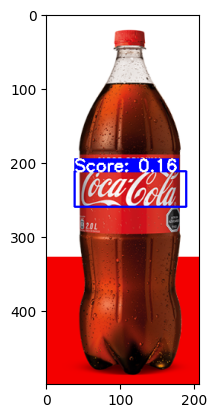

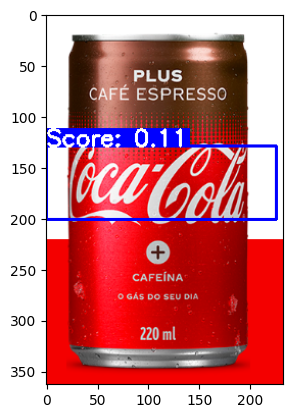

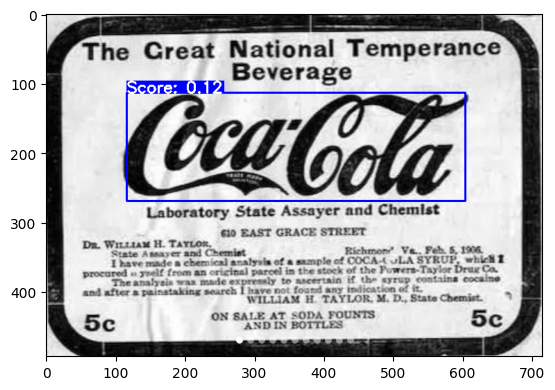

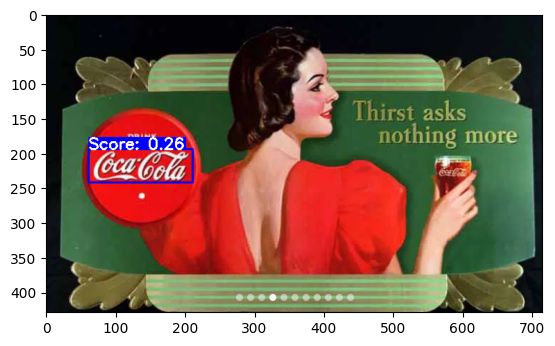

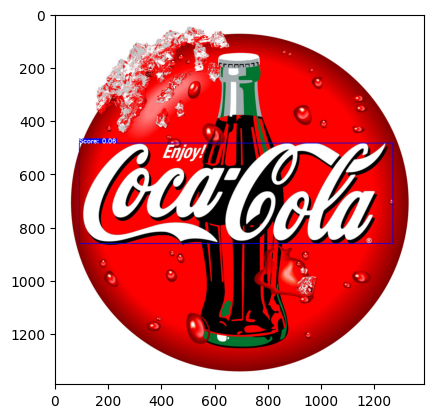

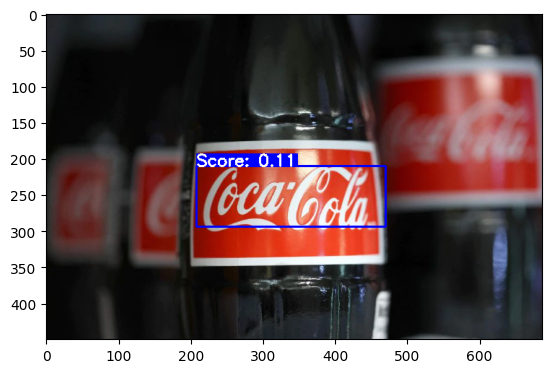

In [8]:
for image in images_rgb:
    best_template, best_score, best_location, prediction = chooseBestMatch(image, trimmed_template)
    final_image = addScoreLabelToBoundingBox(best_score, best_location, prediction)
    plt.figure()
    plt.imshow(final_image, cmap="gray")
    plt.show()

Buscamos en una grilla los parametros para aplicar Canny a las imagenes a procesar. Tambien buscamos en una grilla los tamaños de los templates a matchear. Finalmente calculamos el mejor score y graficamos bounded boxes en cada imagen.

Comparado con el archivo anterior (TP3), podemos observar una mejora total de los aciertos. Esto ocurre ya que no estabamos haciendo correctamente el resize del template en la funcion `chooseBestMatch`.

Podemos observar que si bien los scores son bajos, creemos que esto se debe a que estamos preprocesando las imagens y el template con el extractor de bordes de Canny, con lo cual la simulitd de las areas matcheadas es baja en terminos nominales.

# Ejercicio 2

In [13]:
img_rgb = cv.imread('assets\\images\\coca_multi.png')
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
img_rgb = cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB)

# Aplicar el detector de bordes Canny
img_canny = cv.Canny(img_gray, 100, 200)

In [15]:
nuevo_ancho = int(template.shape[1] * 0.25)
nuevo_alto = int(template.shape[0] * 0.25) 
template_red_mult = cv.resize(template, (nuevo_ancho, nuevo_alto))

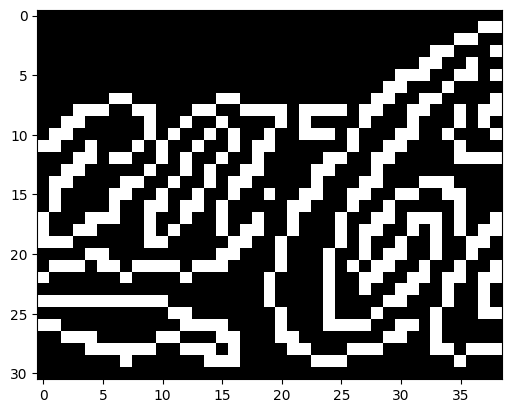

In [16]:
# Recorto template para tener un mejor match
# x1, y1 = 10, 30  # Coordenadas de la esquina superior izquierda
# x2, y2 = 386, 150  # Coordenadas de la esquina inferior derecha

x1, y1 = 26, 7  # Coordenadas de la esquina superior izquierda
x2, y2 = 65, 38  # Coordenadas de la esquina inferior derecha

trimmed_template_2 = template_red_mult[y1:y2, x1:x2]

template_trim_canny = cv.Canny(trimmed_template_2, 100, 200)
plt.imshow(template_trim_canny, cmap='gray')

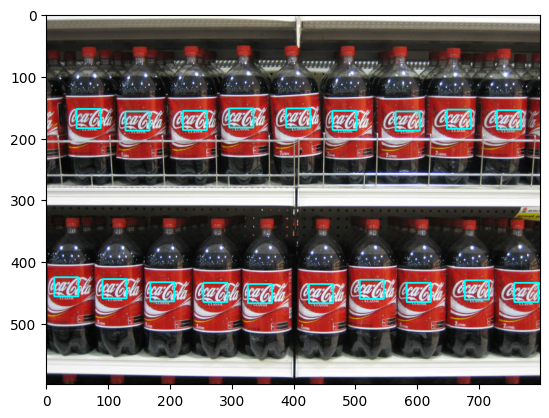

In [17]:
w, h = template_trim_canny.shape[::-1]
res_2= cv.matchTemplate(img_canny,template_trim_canny,cv.TM_CCOEFF_NORMED)

# Fijamos un umbral de "coincidencia"
threshold_2 = 0.25

img_copy = img_rgb.copy()

loc = np.where( res_2 >= threshold_2)
loc = list(zip(*loc[::-1]))

rects = sorted(loc, key=lambda x: x[0])
rects_filtered = []
j=0
rects_filtered.append(rects[0])
for i in range(len(rects)-1):
    if abs(rects_filtered[j][0]-rects[i+1][0]) > 10:
        rects_filtered.append(rects[i+1])
        j=j+1

for rect in rects_filtered:
    cv.rectangle(img_copy, (rect[0], rect[1]), (rect[0] + w, rect[1] + h), (0, 255, 255), 2)

plt.figure()
plt.imshow(img_copy)